In [8]:
import pandas as pd
df = pd.read_csv('nlp_project.csv')
df['school'].unique()

array(['plato', 'aristotle', 'rationalists', 'empiricists',
       'german_idealism', 'analytic', 'phenomenology', 'continental',
       'marxism', 'capitalist_economics', 'abai 45 words'], dtype=object)

In [9]:
df['school'].value_counts(normalize=True)

school
analytic                0.160643
aristotle               0.143655
german_idealism         0.135874
plato                   0.117216
continental             0.106333
phenomenology           0.085825
rationalists            0.079506
capitalist_economics    0.056873
empiricists             0.055484
marxism                 0.054589
abai 45 words           0.004004
Name: proportion, dtype: float64

In [10]:
classes = ['plato', 'aristotle', 'rationalists', 'empiricists',
       'german_idealism', 'analytic', 'phenomenology', 'continental',
       'marxism', 'capitalist_economics']

In [11]:
from sklearn.model_selection import train_test_split

df_train = df[df['school'].isin(classes)]
x_train, x_test, y_train, y_test = train_test_split(df_train['sentence_str'], df_train['school'])

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidvectorizer = TfidfVectorizer(decode_error='ignore', stop_words=[])
tf_idf_data_train = tfidvectorizer.fit_transform(x_train)
tf_idf_data_test = tfidvectorizer.transform(x_test)

In [13]:
from sklearn.naive_bayes import MultinomialNB
nb_classifier = MultinomialNB()
nb_classifier.fit(tf_idf_data_train, y_train)
nb_classifier_preds = nb_classifier.predict(tf_idf_data_test)

In [14]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report
report = classification_report(y_test, nb_classifier_preds, output_dict=True)
macro_avg = report['macro avg']

print("Macro Average Precision:", macro_avg['precision'])
print("Macro Average Recall:", macro_avg['recall'])
print("Macro Average F1-score:", macro_avg['f1-score'])

Macro Average Precision: 0.8040817048725645
Macro Average Recall: 0.6619470026727831
Macro Average F1-score: 0.6934405205798844


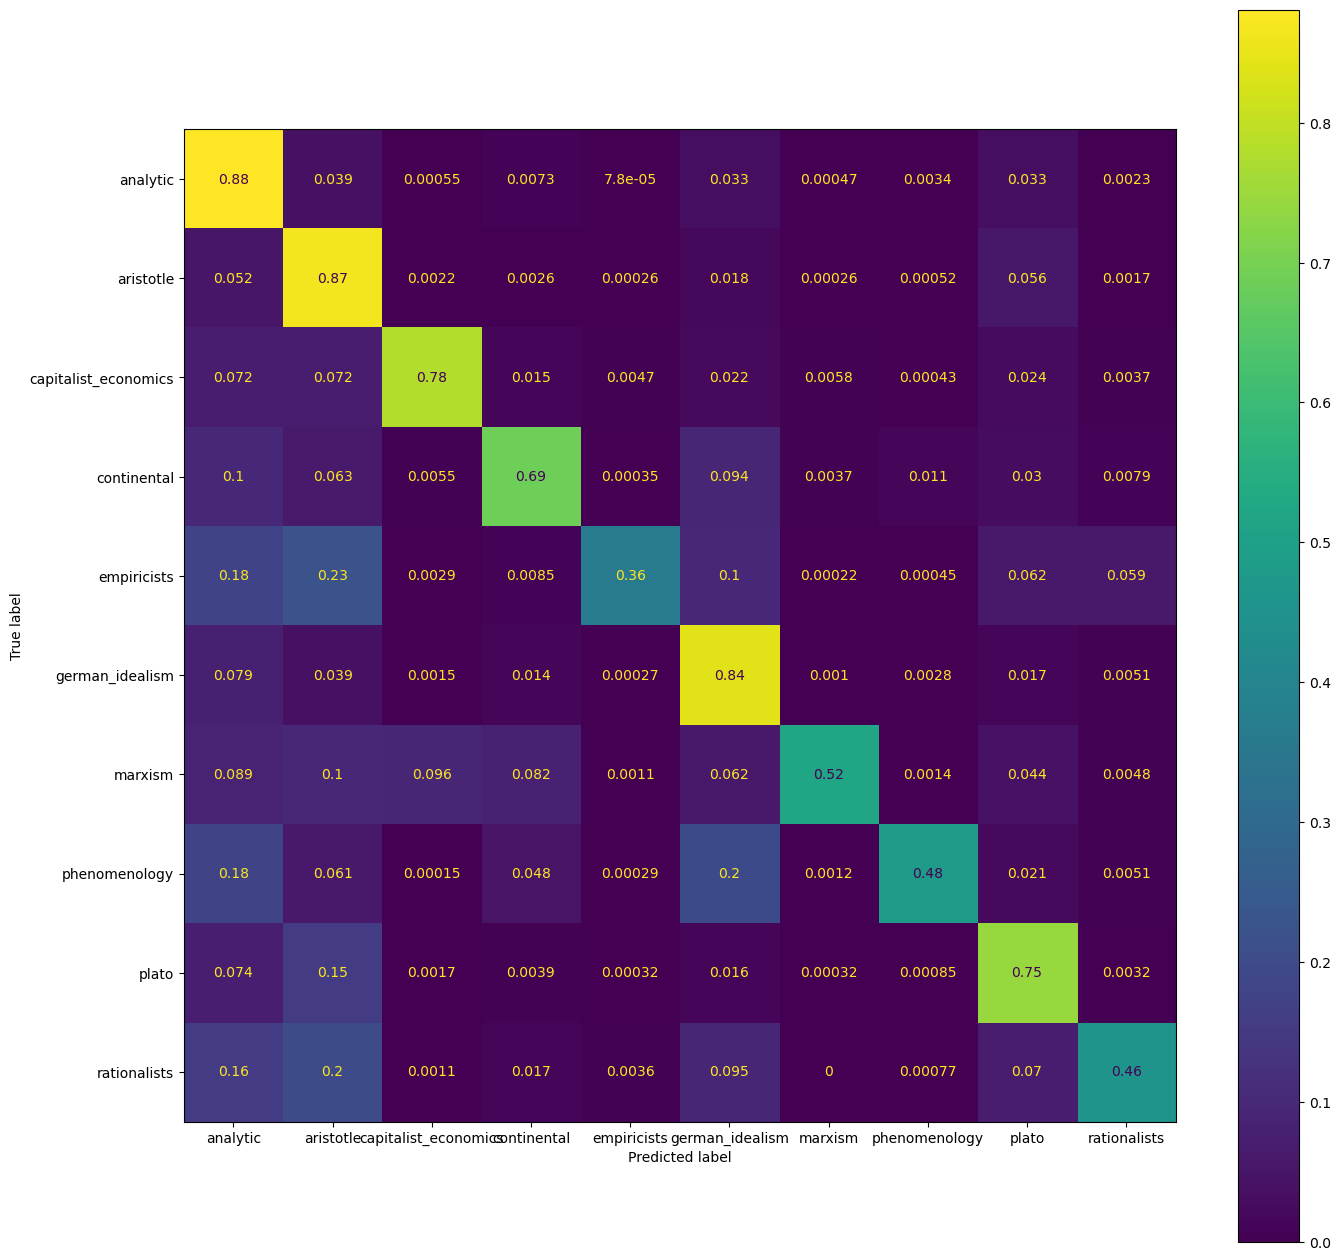

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(16,16))
cm = confusion_matrix(y_test, nb_classifier_preds)
disp = ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=nb_classifier_preds, normalize='true',ax=ax)

In [16]:
df_abai = df[df['school'].isin(['abai 45 words'])]
tfidf_abai = tfidvectorizer.transform(df_abai['sentence_str'])
abai_class = nb_classifier.predict(tfidf_abai)
abai_class

array(['plato', 'german_idealism', 'plato', ..., 'plato', 'aristotle',
       'rationalists'], dtype='<U20')

In [17]:
import re

# Define a function to remove unwanted characters and normalize text
def clean_text(text, capitals=True, bracketed_fn=False, odd_words_dict={}):
    # Remove utf8 encoding characters and some punctuations
    text = re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\xff\xad\x0c6§\\£\Â*_<>""⎫•{}Γ~]', ' ', text)
    text = re.sub(r'[\u2014\u2013\u2012-]', ' ', text)

    # Replace whitespace characters with actual whitespace
    text = re.sub(r'\s', ' ', text)

    # Replace odd quotation marks with a standard
    text = re.sub(r'[‘’“”]', "'", text)

    # Replace the ligatures ﬀ, ﬃ and ﬁ with their appropriate counterparts
    text = re.sub(r'ﬀ', 'ff', text)
    text = re.sub(r'ﬁ', 'fi', text)
    text = re.sub(r'ﬃ', 'ffi', text)

    # Remove or standardize some recurring common and meaningless words/phrases
    text = re.sub(r'\s*This\s*page\s*intentionally\s*left\s*blank\s*', ' ', text)
    text = re.sub(r'(?i)Aufgabe\s+', ' ', text)
    text = re.sub(r',*\s+cf\.', ' ', text)

    # Some texts have footnotes conveniently in brackets - this removes them all,
    # with a safety measure for unpaired brackets, and deletes all brackets afterwards
    if bracketed_fn:
        text = re.sub(r'\[.{0,300}\]|\[.{0,300}\]|\[.{0,300}\}', ' ', text)
    text = re.sub(r'[{}\[\]]', ' ', text)

    # Unify some abbreviations
    text = re.sub(r'&', 'and', text)
    text = re.sub(r'\se\.g\.\s', ' eg ', text)
    text = re.sub(r'\si\.e\.\s', ' ie ', text)
    text = re.sub(r'coroll\.', 'coroll', text)
    text = re.sub(r'pt\.', 'pt', text)

    # Remove roman numerals, first capitalized ones
    text = re.sub(r'\s((I{2,}V*X*\.*)|(IV\.*)|(IX\.*)|(V\.*)|(V+I*\.*)|(X+L*V*I*]\.*))\s', ' ', text)
    # then lowercase
    text = re.sub(r'\s((i{2,}v*x*\.*)|(iv\.*)|(ix\.*)|(v\.*)|(v+i*\.*)|(x+l*v*i*\.*))\s', ' ', text)

    # Remove periods and commas flanked by numbers
    text = re.sub(r'\d\.\d', ' ', text)
    text = re.sub(r'\d,\d', ' ', text)

    # Remove the number-letter-number pattern used for many citations
    text = re.sub(r'\d*\w{,2}\d', ' ', text)

    # Remove numerical characters
    text = re.sub(r'\d+', ' ', text)

    # Remove words of 2+ characters that are entirely capitalized
    # (these are almost always titles, headings, or speakers in a dialogue)
    # remove capital I's that follow capital words - these almost always roman numerals
    # some texts do use these capitalizations meaningfully, so we make this optional
    if capitals:
        text = re.sub(r'[A-Z]{2,}\s+I', ' ', text)
        text = re.sub(r'[A-Z]{2,}', ' ', text)

    # Remove isolated colons and semicolons that result from removal of titles
    text = re.sub(r'\s+:\s*', ' ', text)
    text = re.sub(r'\s+;\s*', ' ', text)

    # Remove isolated letters (do it several times because strings of isolated letters do not get captured properly)
    text = re.sub(r'\s[^aAI\.]\s', ' ', text)
    text = re.sub(r'\s[^aAI\.]\s', ' ', text)
    text = re.sub(r'\s[^aAI\.]\s', ' ', text)
    text = re.sub(r'\s[^aAI\.]\s', ' ', text)
    text = re.sub(r'\s[^aAI\.]\s', ' ', text)
    text = re.sub(r'\s[^aAI\.]\s', ' ', text)

    # Remove isolated letters at the end of sentences or before commas
    text = re.sub(r'\s[^aI]\.', '.', text)
    text = re.sub(r'\s[^aI],', ',', text)

    # Deal with spaces around periods and commas
    text = re.sub(r'\s+,\s+', ', ', text)
    text = re.sub(r'\s+\.\s+', '. ', text)

    # Reduce multiple periods, commas, or whitespaces into a single one
    text = re.sub(r'\.+', '.', text)
    text = re.sub(r',+', ',', text)
    text = re.sub(r'\s+', ' ', text)

    # Deal with isolated problem cases discovered in the data:
    for key in odd_words_dict.keys():
        text = re.sub(r''+key+'', odd_words_dict[key], text)

    return text.strip()


In [18]:
import os
drive_path = r"C:\Users\margu\OneDrive\Рабочий стол\Main\KBTU\second_semester\NLP\NLP_Project\datasets"
def get_text(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        return clean_text(file.read())
    

abai_path = os.path.join(drive_path, 'abai')

abai_texts = {}
for filename in os.listdir(abai_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(abai_path, filename)
        abai_texts[filename] = get_text(file_path)

for name, text in abai_texts.items():
    print(f"Snippet from {name}:", text[:100])

Snippet from word_1.txt: Whether for good or ill, I have lived my life, travel ling a long road fraught with struggles and qu
Snippet from word_10.txt: People pray to God to send them a child. What does a man need a child for? They say that one ought t
Snippet from word_11.txt: How do our people make living? There are two ways. One is by stealing. A thief hopes to grow fat on 
Snippet from word_12.txt: When someone teaches the Word of God, whether he does it well or badly, we would sooner bite of our 
Snippet from word_13.txt: man this is the unshakeable faith in one, all power full Creator, about whose essence and existence 
Snippet from word_14.txt: Has man anything more precious than his heart? Calling someone a man of brave heart, people respect 
Snippet from word_15.txt: Word Fifteen There is an essential difference, in my view, between intelligent and stupid people. Co
Snippet from word_16.txt: The Kazakh does not worry whether his prayers please God or not. Не does what other pe

In [19]:
texts = []
for val in abai_texts.values():
    texts.append(val)

In [20]:
joined_text = " ".join(texts) 
tfidf_abai_texts = tfidvectorizer.transform([joined_text])
abai_class_texts = nb_classifier.predict(tfidf_abai_texts)
abai_class_texts

array(['plato'], dtype='<U20')

In [21]:
# from sklearn.ensemble import RandomForestClassifier
# random_clf = RandomForestClassifier(n_estimators=20, random_state=42)
# random_clf.fit(tf_idf_data_train, y_train)

In [22]:
# y_pred = random_clf.predict(x_test)

In [23]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]  # Take the output of the last time step
        fc_out = self.fc(lstm_out)
        return self.softmax(fc_out)

def make_model(vocab_size, embedding_size=256, hidden_size=50, output_size=10):
    model = LSTMModel(vocab_size, embedding_size, hidden_size, output_size)
    return model

# Example usage:
# Replace vocab_size with the actual vocabulary size from your tokenizer
vocab_size = 10000  # Replace with actual vocabulary size
model = make_model(vocab_size)
print(model)


LSTMModel(
  (embedding): Embedding(10000, 256)
  (lstm): LSTM(256, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import torch
from sklearn.preprocessing import LabelEncoder
import numpy as np


# Tokenize the sentences
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_sentences = [tokenizer.encode(sent, add_special_tokens=True) for sent in df_train['sentence_str']]

# Pad sequences
max_sequence_length = max(len(seq) for seq in tokenized_sentences)
padded_sentences = [sent + [tokenizer.pad_token_id] * (max_sequence_length - len(sent)) for sent in tokenized_sentences]
padded_sentences = torch.tensor(padded_sentences)

# Encode labels
label_encoder = LabelEncoder()
df_train['school'] = label_encoder.fit_transform(df_train['school'])
encoded_labels = torch.tensor(df_train['school'].values)

# Split the data into train and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(padded_sentences, encoded_labels, test_size=0.2, random_state=42)

# Define hyperparameters
vocab_size = len(tokenizer)
embedding_size = 256
hidden_size = 50
output_size = len(df_train['school'].unique())  # Number of classes

# Create custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

# Create datasets and dataloaders
train_dataset = CustomDataset(x_train, y_train)
valid_dataset = CustomDataset(x_valid, y_valid)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)

# Initialize the model
model = make_model(vocab_size, embedding_size, hidden_size, output_size)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model and data to GPU if available
model.to(device)
x_train, y_train = x_train.to(device), y_train.to(device)
x_valid, y_valid = x_valid.to(device), y_valid.to(device)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU
        outputs = model(inputs)
        
        # Convert targets to LongTensor
        targets = targets.long()
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for inputs, targets in valid_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)
            total_correct += (predicted == targets).sum().item()
            total_samples += targets.size(0)

        accuracy = total_correct / total_samples
        print(f'Epoch {epoch+1}, Validation Accuracy: {accuracy:.4f}')

Token indices sequence length is longer than the specified maximum sequence length for this model (7062 > 512). Running this sequence through the model will result in indexing errors


MemoryError: 